In [1]:
import torch
import torch.nn
import numpy as np
from sklearn.metrics import accuracy_score
from imblearn.metrics import sensitivity_specificity_support
import seaborn as sns
import matplotlib.pyplot as plt

from model import FCL_Model

from utils import load_dataset
from utils import split_data
from utils import get_hidden_sizes

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score

In [2]:
model_fn = "./test.pth"

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
def load(fn, device):
    d = torch.load(fn, map_location=device)
    
    return d['model'], d['config']

def adjusted_r2(yhat, y):
    SS_Residual = sum((y-yhat)**2)
    SS_Total = sum((y-np.mean(y))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-x.shape[1]-1)
    return adjusted_r_squared

def plot_balnd_altman(y_hat, y):
    
    f, ax = plt.subplots(1, figsize = (10, 10))
    sm.graphics.mean_diff_plot(y_hat, y, ax = ax)
    plt.show()
    
    return None

def plot_asym(y_hat, y):

    plt.figure(figsize=(10, 10))
    plt.scatter(y=y_hat, x=y)
    plt.show()

    return None

def plot_roc_prc(y_hat, y):
    fpr, tpr, _ = roc_curve(y, y_hat, pos_label=1)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
    
    prec, recall, _ = precision_recall_curve(y, y_hat, pos_label=1)
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    roc_display.plot(ax=ax1)
    pr_display.plot(ax=ax2)
    plt.show()

    

In [5]:
def test(model, x, y):
    model.eval()
    
    with torch.no_grad():
        y_hat = model(x).to(torch.device('cpu')).numpy().reshape(-1, 1)
        y = y.to(torch.device('cpu')).numpy().reshape(-1, 1)
        
        accuracy = accuracy_score(y_pred=(y_hat > 0.5), y_true=y)
        sensitivity, specificity, _ = sensitivity_specificity_support(y_true=y, y_pred=(y_hat > 0.5), average='binary')

        print("Accuracy: {}".format(accuracy))
        print("Sensitivity: {}".format(sensitivity))
        print("Specificity: {}".format(specificity))
        print("AUROC: {}".format(roc_auc_score(y, y_hat)))
        
        plot_roc_prc(y_hat, y)

Accuracy: 0.881578947368421
Sensitivity: 0.7413793103448276
Specificity: 0.9680851063829787
AUROC: 0.9361702127659574


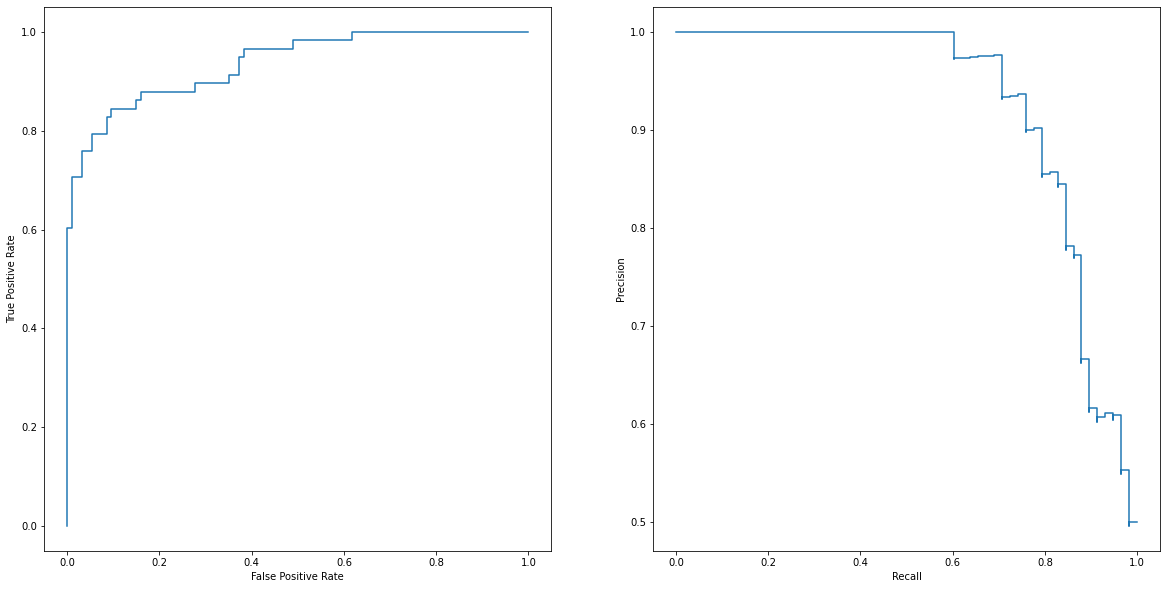

In [6]:
# Load MNIST test set.
x, y = load_dataset()
x, y = split_data(x, y, train_ratio=0.8, device=device)
# Reshape tensor to chunk of 1-d vectors.
x = x[1]
y = y[1]

input_size = int(x.shape[-1])
output_size = 1

model_dict, train_config = load(model_fn, device)

model = FCL_Model(
    input_size=input_size,
    output_size=output_size,
    hidden_sizes=get_hidden_sizes(input_size, output_size,
                                      train_config.n_layers,
                                      train_config.n_node_first_hidden),
    use_batch_norm=not train_config.use_dropout,
    dropout_p=train_config.dropout_p,
).to(device)

model.load_state_dict(model_dict)

test(model, x, y)